In [2]:
import nengo
from nengo.dists import Uniform
import numpy as np
import matplotlib.pyplot as plt
from nengo.utils.matplotlib import rasterplot
from nengo.utils.ensemble import tuning_curves
from nengo.dists import Choice


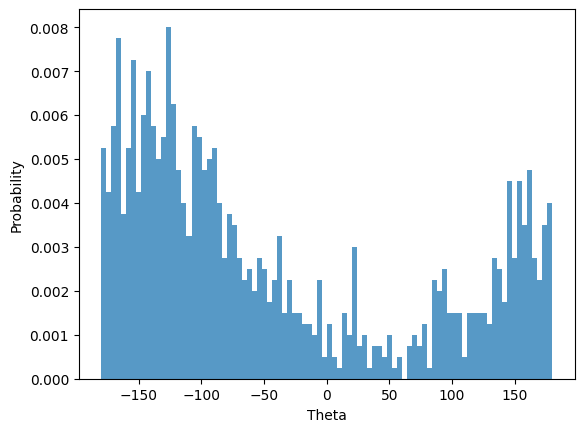

In [3]:
rng = np.random.default_rng()
theta = np.rad2deg(rng.vonmises(np.deg2rad(225), 1, 1000))

def plot_angle_distribution(ax: plt.Axes, thetas: np.ndarray, density: bool = True):
    ax.hist(thetas, bins = 90, density=density, alpha = 0.75)
    ax.set_xlabel('Theta')
    ax.set_ylabel('Probability' if density else 'Frequency')

fig, ax = plt.subplots(1, 1)
plot_angle_distribution(ax, theta)
plt.show()

## Generate an input signal from the movement of dots

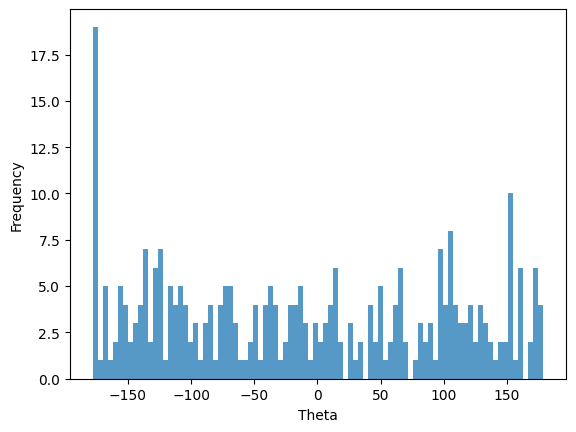

In [4]:
def generate_dot_directions(
    motion_direction_deg: float,
    vonmises_concentration: float,
    num_dots: int,
    coherence: float,
):
    coherent_direction = np.rad2deg(rng.vonmises(np.deg2rad(motion_direction_deg), vonmises_concentration))
    directions = rng.integers(-180, 180, size = num_dots)
    # select a % of the dots
    coherent_dots_index = rng.choice(np.arange(0, len(directions)), size = int(coherence * len(directions)), replace = False)
    directions[coherent_dots_index] = coherent_direction
    return directions
    
thetas = generate_dot_directions(225, 2.0, 300, 0.05)
fig, ax = plt.subplots(1, 1)
plot_angle_distribution(ax, thetas, density = False)
plt.show()


# Create a single neuron population that receives a Sine wave as input

In [5]:
model = nengo.Network()
with model:
    input = nengo.Node(lambda x: np.sin(10*x))
    ensemble = nengo.Ensemble(
        1,
        dimensions = 1, # State space has a single dimension (i.e a scalar)
        intercepts = Uniform(-0.5, 0.5), # Represents the 0 values of the dimension
        max_rates = Uniform(100, 100), # Neuron only fires at 100Hz max
        encoders = [[1]], # N x M where N = # of neurons, M = # of dimensions of input space. This represents how inputs are converted into Neuron representational space.
    )

    nengo.Connection(input, ensemble)
    
    # Set up probes
    input_probe = nengo.Probe(input)
    # The raw spikes from the neuron
    spikes = nengo.Probe(ensemble.neurons)
    # Subthreshold soma voltage of the neuron
    voltage = nengo.Probe(ensemble.neurons, "voltage")
    # Spikes filtered by a 10ms post-synaptic filter
    filtered = nengo.Probe(ensemble, synapse=0.01)
    
with nengo.Simulator(model) as sim:
    sim.run(1) # 1 second

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

(0.0, 1.0)

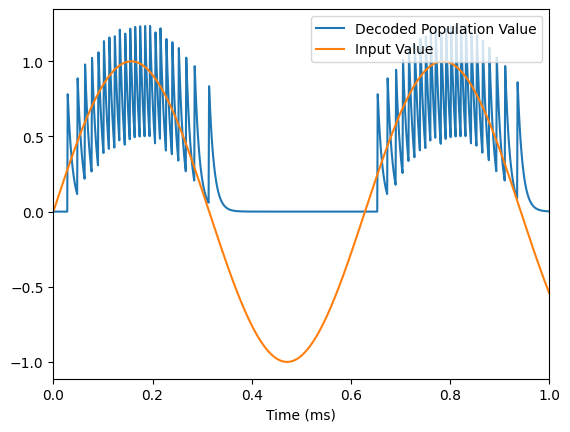

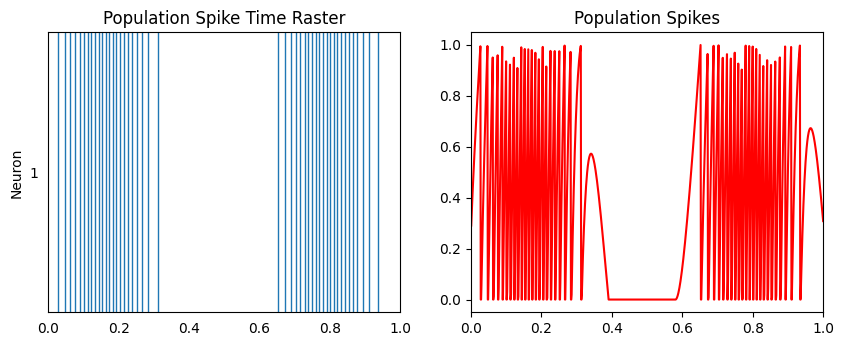

In [6]:
# Plot the decoded output of the ensemble
plt.figure()
plt.plot(sim.trange(), sim.data[filtered], label = "Decoded Population Value")
plt.plot(sim.trange(), sim.data[input_probe], label = "Input Value")
plt.xlabel("Time (ms)")
plt.legend(loc = "upper right")
plt.xlim(0, 1)

# Plot the spiking output of the ensemble
plt.figure(figsize=(10, 8))
plt.subplot(221)
plt.title("Population Spike Time Raster")
rasterplot(sim.trange(), sim.data[spikes])
plt.ylabel("Neuron")
plt.xlim(0, 1)

# Plot the soma voltages of the neurons
plt.subplot(222)
plt.title("Population Spikes")
plt.plot(sim.trange(), sim.data[voltage][:, 0], "r")
plt.xlim(0, 1)

# Create a population with many neurons receiving a scalar input

In [7]:
model = nengo.Network()
with model:
    input = nengo.Node(lambda x: np.sin(10*x))
    ensemble = nengo.Ensemble(
        10,
        dimensions = 1,
        max_rates = Uniform(100, 200),
        intercepts = Uniform(-0.5, 0.5),
    )

    nengo.Connection(input, ensemble)

    # Set up probes
    input_probe = nengo.Probe(input)
    # The raw spikes from the neuron
    spikes = nengo.Probe(ensemble.neurons)
    # Subthreshold soma voltage of the neuron
    voltage = nengo.Probe(ensemble.neurons, "voltage")
    # Spikes filtered by a 10ms post-synaptic filter
    filtered = nengo.Probe(ensemble, synapse=0.01)

with nengo.Simulator(model) as sim:
    sim.run(1) # 1 second

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

(0.0, 1.0)

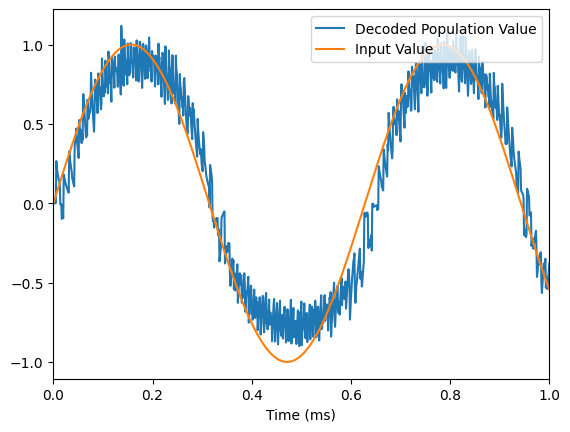

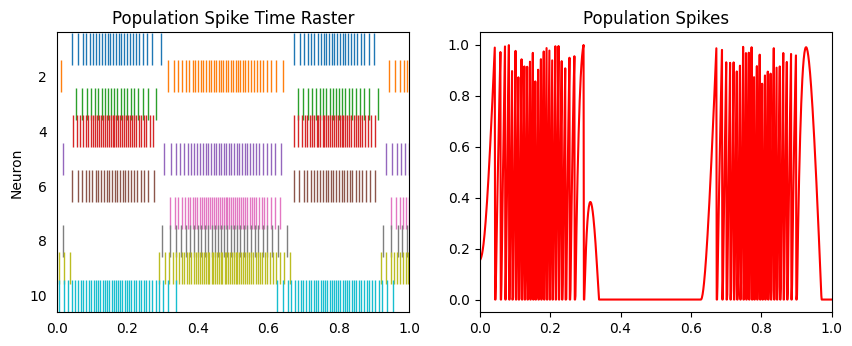

In [8]:
# Plot the decoded output of the ensemble
plt.figure()
plt.plot(sim.trange(), sim.data[filtered], label = "Decoded Population Value")
plt.plot(sim.trange(), sim.data[input_probe], label = "Input Value")
plt.xlabel("Time (ms)")
plt.legend(loc = "upper right")
plt.xlim(0, 1)

# Plot the spiking output of the ensemble
plt.figure(figsize=(10, 8))
plt.subplot(221)
plt.title("Population Spike Time Raster")
rasterplot(sim.trange(), sim.data[spikes])
plt.ylabel("Neuron")
plt.xlim(0, 1)

# Plot the soma voltages of the neurons
plt.subplot(222)
plt.title("Population Spikes")
plt.plot(sim.trange(), sim.data[voltage][:, 0], "r")
plt.xlim(0, 1)

## Plot tuning curves for scalar representation

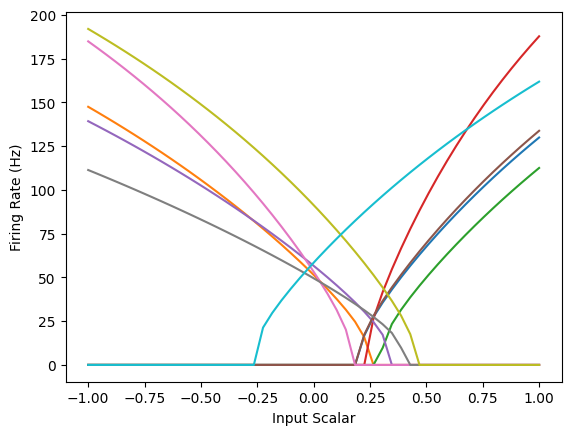

In [9]:
plt.figure()
plt.plot(*tuning_curves(ensemble, sim))
plt.ylabel("Firing Rate (Hz)")
plt.xlabel("Input Scalar")
plt.show()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Text(0.5, 0, 'Input scalar, x')

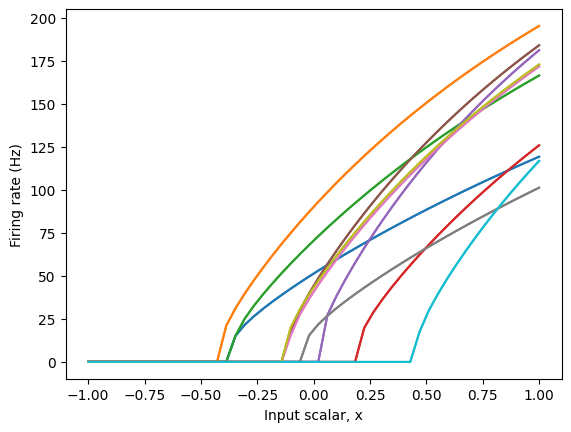

In [10]:
ensemble.encoders = Choice([[1]])

with nengo.Simulator(model) as sim:
    plt.plot(*tuning_curves(ensemble, sim))
plt.plot(*tuning_curves(ensemble, sim))
plt.ylabel("Firing rate (Hz)")
plt.xlabel("Input scalar, x")

# Explorations in Learning

What happens when you pass the scalar signal across two populations of Neurons?

In [11]:
model = nengo.Network()
with model:
    input = nengo.Node(lambda x: np.sin(10*x))
    pre = nengo.Ensemble(
        10,
        dimensions = 1,
        max_rates = Uniform(100, 200),
        intercepts = Uniform(-0.5, 0.5),
    )
    post = nengo.Ensemble(5, dimensions = 1)
    error = nengo.Ensemble(20, dimensions = 1)
    error_p = nengo.Probe(error, synapse=0.03)


    nengo.Connection(input, pre)
    pre_post_conn = nengo.Connection(pre, post, function = lambda x: rng.random())

    # Error = actual - target = post - pre
    nengo.Connection(post, error)
    nengo.Connection(pre, error, transform=-1)

    pre_post_conn.learning_rule_type = nengo.PES()
    nengo.Connection(error, pre_post_conn.learning_rule)
    
    # Set up probes
    input_probe = nengo.Probe(input)
    # The raw spikes from the neuron
    pre_spikes = nengo.Probe(pre.neurons)
    # Spikes filtered by a 10ms post-synaptic filter
    pre_decoded = nengo.Probe(pre, synapse=0.01)

    post_spikes = nengo.Probe(post.neurons)
    # Spikes filtered by a 10ms post-synaptic filter
    post_decoded = nengo.Probe(post, synapse=0.01)

with nengo.Simulator(model) as sim:
    sim.run(5.0) # 1 second

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

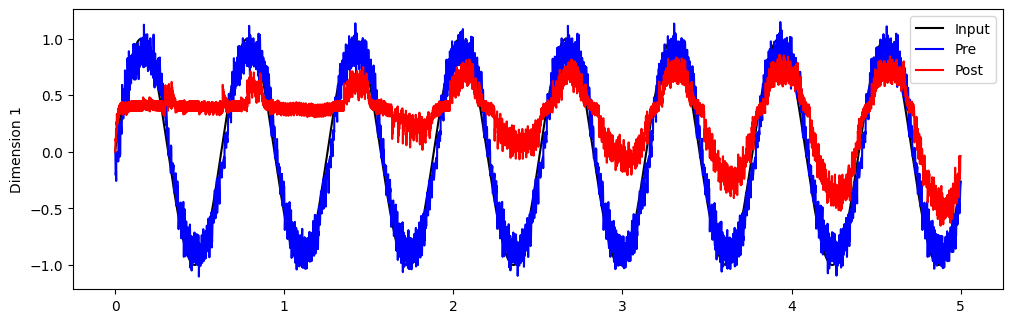

In [12]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(sim.trange(), sim.data[input_probe].T[0], c="k", label="Input")
plt.plot(sim.trange(), sim.data[pre_decoded].T[0], c="b", label="Pre")
plt.plot(sim.trange(), sim.data[post_decoded].T[0], c="r", label="Post")
plt.ylabel("Dimension 1")
plt.legend(loc="best")

In [13]:
np.random.random(2)

array([0.20443791, 0.47635934])

# Learning vectors on a unit circle (i.e motion directions)

## Let's first generate some angles, and plot their unit vectors

In [14]:
def create_unit_vectors_from_thetas(thetas: np.ndarray) -> np.ndarray:
    radians = np.deg2rad(thetas)
    x = np.cos(radians)
    y = np.sin(radians)
    vectors = np.column_stack((x, y))
    return vectors

def plot_unit_vectors(vectors: np.ndarray, alpha: float = 0.1) -> None:
     # Create a unit circle
    circle = plt.Circle((0, 0), 1, color='blue', fill=False, linestyle='--')

    fig, ax = plt.subplots()
    ax.add_artist(circle)

    # Plot each vector
    for vector in vectors:
        ax.plot([0, vector[0]], [0, vector[1]], 'r-', alpha=alpha)

    # Set the aspect ratio of the plot to be equal
    ax.set_aspect('equal')

    # Set limits to make sure the circle is visible
    ax.set_xlim([-1.5, 1.5])
    ax.set_ylim([-1.5, 1.5])

     # Plot axis lines
    ax.plot([-1.5, 1.5], [0, 0], 'k--', alpha=0.7)  # X-axis
    ax.plot([0, 0], [-1.5, 1.5], 'k--', alpha=0.7)  # Y-axis

    # Add grid
    ax.grid(True)

    # Display the plot
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Unit Vectors on a Unit Circle')
    plt.show()

thetas = generate_dot_directions(225, 2.0, 300, 0.10)
vectors = create_unit_vectors_from_thetas(thetas)

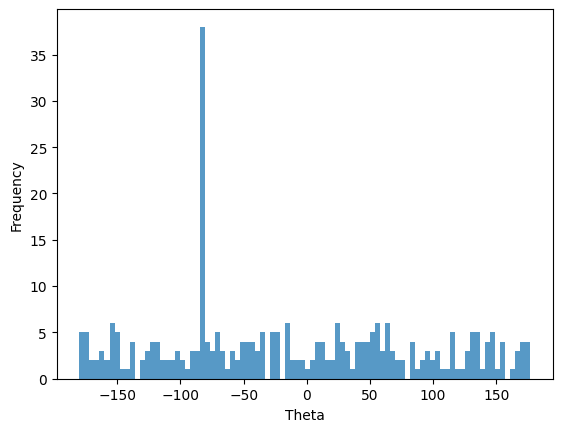

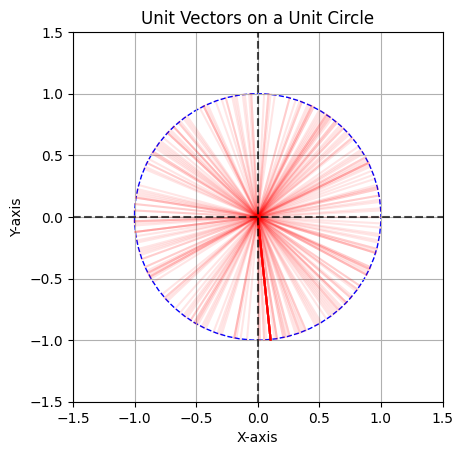

In [15]:
fig, ax = plt.subplots(1, 1)
plot_angle_distribution(ax, thetas, density = False)
plot_unit_vectors(vectors)
plt.show()

## Now let's implement a circuit that can learn this vector

In [16]:
class VectorInput:
    def __init__(self, vectors: np.ndarray):
        self.vectors = vectors
        self.current = 0
    
    def step(self):
        if self.current >= self.vectors.shape[0]:
            return [0.0, 0.0]
        current_vector = self.vectors[self.current, :]
        self.current += 1
        return current_vector

model = nengo.Network()
with model:
    vector_inputs = VectorInput(vectors)
    input = nengo.Node(lambda t, x: vector_inputs.step(), size_in = 2) # Pass in 2D vectors
    ensemble = nengo.Ensemble(
        10,
        dimensions = 2,
    )
    nengo.Connection(input, ensemble)
    input_probe = nengo.Probe(input)
    # The raw spikes from the neuron
    filtered = nengo.Probe(ensemble, synapse=0.01)

with nengo.Simulator(model) as sim:
    sim.run(0.5) # 1 second

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

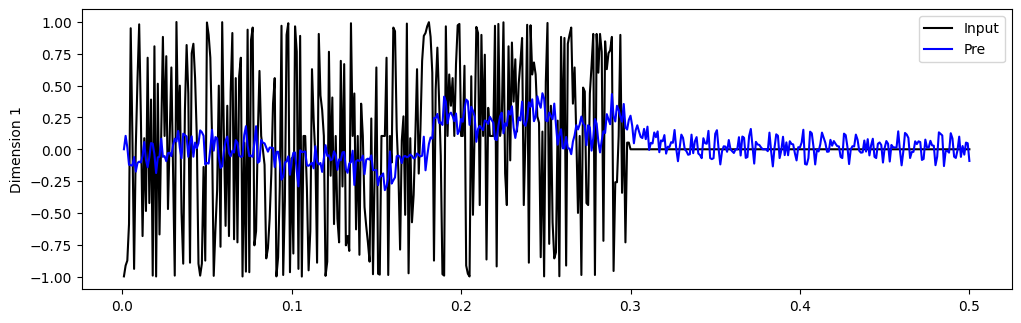

In [17]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(sim.trange(), sim.data[input_probe].T[0], c="k", label="Input")
plt.plot(sim.trange(), sim.data[filtered].T[0], c="b", label="Pre")
plt.ylabel("Dimension 1")
plt.legend(loc="best")